In [1]:
import numpy as np
import h5py
import treecorr

In [2]:
path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/'


In [3]:
with h5py.File(path+"binned_star_catalog.hdf5",'r') as f:
    b = f['stars/bin_bright/']
    cat_sb = treecorr.Catalog(
                ra=b["ra"][:],
                dec=b["dec"][:],
                ra_units="degree",
                dec_units="degree",
                npatch=40,
            )
    d = f['stars/bin_dim/']
    cat_sd = treecorr.Catalog(
                    ra=d["ra"][:],
                    dec=d["dec"][:],
                    ra_units="degree",
                    dec_units="degree",
                    patch_centers=cat_sb.patch_centers,
            )
with h5py.File(path+"randoms_desy3_RM.hdf5",'r') as f:
    r = f["randoms/"]
    rancat = treecorr.Catalog(
                ra=r["ra"][:],
                dec=r["dec"][:],
                ra_units="degree",
                dec_units="degree",
                patch_centers=cat_sb.patch_centers,
            )

In [4]:
def apply_metacal_response(R, S, g1, g2):
    # The values of R are assumed to already
    # have had appropriate weights included
    from numpy.linalg import pinv
    import numpy as np

    mcal_g = np.stack([g1, g2], axis=1)

    R_total = R + S

    # Invert the responsivity matrix
    Rinv = pinv(R_total)
    mcal_g = Rinv @ mcal_g.T

    return mcal_g[0], mcal_g[1]

In [5]:
path2 = '../../TXPipe/data/desy3/outputs/'
with h5py.File(path2+'shear_tomography_catalog.hdf5','r') as f:
    source_bin = f['tomography/bin'][:]
    mask = source_bin != -1  # Only use the sources that pass the fiducial cuts
    R_total_2d = f['response/R_S_2d'][:] + f['response/R_gamma_mean_2d'][:]

with h5py.File(path+'shear_catalog_desy3_unmasked_withfakez.hdf5','r') as f:
    g = f['shear']
    g1      = g['mcal_g1'][:][mask]
    g2      = g['mcal_g2'][:][mask]
    gw  = g['weight'][:][mask]
    gra,gdec = g['ra'][:][mask], g['dec'][:][mask]

print('Applying metacal/metadetect response')
g1, g2 = apply_metacal_response(R_total_2d, 0.0, g1, g2)


gg = np.array((g1, g2))

Applying metacal/metadetect response


In [6]:
catg = treecorr.Catalog(ra=gra,
                        dec=gdec,
                        g1=gg[0],
                        g2=gg[1],
                        w=gw,
                        ra_units="deg",
                        dec_units="deg",
                        patch_centers=cat_sb.patch_centers) # galaxy shear


In [7]:
config = {"min_sep": 0.5,
        "max_sep": 300.0,
        "nbins": 20,
        "bin_slop": 0.01,
        "sep_units": "arcmin",
        "auto_only": False,
        "var_method": "jackknife",
    }
nsbg = treecorr.NGCorrelation(config)
nsdg = treecorr.NGCorrelation(config)

rg = treecorr.NGCorrelation(config)

In [8]:
nsbg.process(cat_sb, catg, low_mem=True)
nsdg.process(cat_sd, catg, low_mem=True)
rg.process(rancat, catg, low_mem=True)

In [9]:
nsbg.calculateXi(rg=rg)
nsdg.calculateXi(rg=rg)

(array([-2.10790759e-04, -7.06567587e-05, -1.93969168e-05,  5.88657064e-05,
         9.27670574e-05,  1.15108057e-04,  9.50110769e-05,  8.37656008e-05,
         7.89816210e-05,  6.00209985e-05,  4.98366987e-05,  4.30794829e-05,
         3.49655996e-05,  3.07452053e-05,  2.82625051e-05,  2.26658251e-05,
         1.81890047e-05,  1.21755245e-05,  9.80266922e-06,  6.92232346e-06]),
 array([ 7.59326138e-05,  4.46601763e-06, -1.26539664e-05,  4.07181551e-06,
        -9.47221491e-06,  2.71464601e-07,  3.53185633e-06, -4.16954083e-06,
         5.63798627e-07,  3.09501669e-06, -1.64910240e-06,  2.59516500e-07,
        -3.40030595e-06, -4.40328235e-07, -4.60449524e-06, -4.37324537e-06,
        -4.63304048e-06, -2.60552291e-06,  8.02632373e-07,  8.50759210e-08]),
 array([1.67703852e-09, 1.09013447e-09, 6.42484175e-10, 3.34882285e-10,
        1.56752484e-10, 8.07547027e-11, 4.32953347e-11, 7.06691952e-11,
        3.46804066e-11, 1.78416028e-11, 1.74366561e-11, 7.25140916e-12,
        8.00326968e-

In [10]:
nsbg.xi
#nsbg.meanr


array([ 6.99043256e-05,  5.40089003e-04,  1.41952371e-04,  2.62623783e-04,
        6.10199205e-05,  6.44520281e-05,  1.29057029e-04,  3.15963142e-06,
       -8.91847885e-06,  3.47854815e-06,  2.30695404e-05,  1.05216875e-05,
        6.84838428e-06, -1.41097123e-05, -5.57501566e-06,  4.33087201e-06,
        3.54803276e-06, -5.78509689e-07, -6.53555466e-07,  2.99206807e-06])

Text(0.5, 0, '$\\theta$ arcmin')

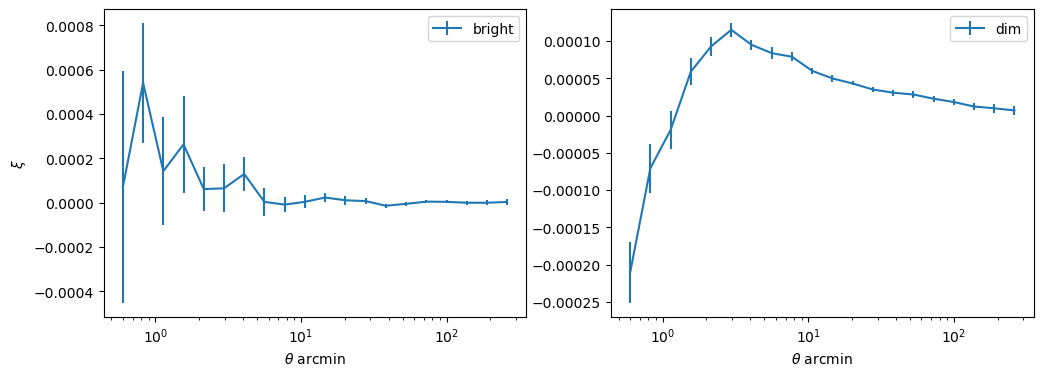

In [16]:
import matplotlib.pyplot as plt
fig, axs  = plt.subplots(1,2, figsize = [12,4])
ax1,ax2 = axs.flatten()
ax1.errorbar(nsbg.meanr,nsbg.xi,nsbg.varxi**0.5,label='bright')
ax1.set_xscale('log')
ax1.legend()
ax1.set_ylabel(r'$\xi$')
ax1.set_xlabel(r'$\theta$ arcmin')

ax2.errorbar(nsdg.meanr,nsdg.xi,nsdg.varxi**0.5,label='dim')
ax2.set_xscale('log')
ax2.legend()
#ax2.set_ylabel(r'$\xi$')
ax2.set_xlabel(r'$\theta$ arcmin')